In [116]:
import math
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [117]:
#edit the input file name
input_data_file = 'Restaurant_Domain_Dataset.xlsx'
dataframe = pd.DataFrame(pd.read_excel(input_data_file, index_col = 0))
allattributes = ['Alternate_Available', 'Bar', 'Friday', 'Hungry', 'Patrons', 'Price',
       'Rain', 'Reservation', 'Type', 'Estimated_Wait_Time']
dataframe

,Alternate_Available,Bar,Friday,Hungry,Patrons,Price,Rain,Reservation,Type,Estimated_Wait_Time,WillWait
Sample,,,,,,,,,,,
x1,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
x2,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
x3,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
x4,Yes,No,Yes,Yes,Full,$,Yes,No,Thai,10-30,Yes
x5,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
x6,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
x7,No,Yes,No,No,NaN,$,Yes,No,Burger,0-10,No
x8,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
x9,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No


In [118]:
def calculate_output_entropy(dataframe, target_variable):
    # Count the occurrences of each class label
    class_counts = dataframe[target_variable].value_counts()
    total_instances = len(dataframe)
    
    # Calculate the entropy
    entropy = 0.0
    
    for count in class_counts:
        probability = count / total_instances
        
        if (probability != 0):
            entropy -= probability * math.log2(probability)
    
    return entropy

out_entropy = calculate_output_entropy(dataframe, 'WillWait')
print("Entropy:", out_entropy)

Entropy: 0.9798687566511528


In [119]:
def entropy(probability):
    result = 0
    if probability == 1:
        result = (probability * math.log2(probability))*(-1)
    elif probability == 0:
        result = ((1-probability) * math.log2(1-probability))*(-1)
    else:
        result = ((probability * math.log2(probability)) + ((1-probability) * math.log2(1-probability)))*(-1)
    return result 

print(entropy(1/2))

1.0


In [111]:
def max_gain(dataframe, attributes):
    
    out_entropy = calculate_output_entropy(dataframe, 'WillWait')
    
    total_instances = len(dataframe)
    
    gain = []
    remainder = 0
    
    for index in range(dataframe.shape[1]): #iterating columns
        
        
        
        column = dataframe.iloc[:, index]
        
        # Optional: don't calculate the gain of an already used attribute
        if (not (column.name in attributes)):
            continue
        
        
        uniques= dataframe[column.name].unique()
        
        for u in uniques:
            cond_ = dataframe[column.name].isin([u])
            unique_df = dataframe.loc[cond_,:]
            #print("\n\nUNIQUEDATAFRAME:", unique_df)
            bag = len(unique_df)
            
            cond_ = dataframe["WillWait"].isin(["Yes"])
            uniqueWillWait = unique_df.loc[cond_,:]            
            
            thisEntropy = entropy((len(uniqueWillWait))/bag)
            remainder += (bag/total_instances) * thisEntropy
            
        
            
        #print("\nREMAINDER: ", remainder)
        gain.append(out_entropy - remainder)
        #print("\nGAIN: ", gain)
        remainder = 0

        
    return(attributes[gain.index(max(gain))])


                    
max_gain(dataframe, allattributes)  

'Patrons'

In [112]:
class Node(object):
    def __init__(self, entropy, result, attribute):
        self.entropy = entropy
        self.result = result
        self.attribute = attribute
        self.children = []

    def add_child(self, obj):
        self.children.append(obj)
        
    def children(self):
        return self.children
    
    def getAttribute(self):
        return self.attribute
    
    def setAttribute(self, attr):
        self.attribute = attr
    
    def setResult(self, res):
        self.result = res


In [113]:
# Decision Tree

def decision_tree(node, dataframe, attributes):
    
    #if dataframe is empty, exit the recursion
    if len(dataframe.columns) == 0 or dataframe.empty: 
        return
    
    # Find the best attribute for splitting and remove it from attributes
    best_attr = max_gain(dataframe, attributes)
    attributes.remove(best_attr)
    #print("\nbest attribute: ", best_attr )
    
    if not (node.attribute):
        node.setAttribute(best_attr)
        node.setResult(best_attr)
    

    uniques= dataframe[best_attr].unique()

    for u in uniques:
        cond_ = dataframe[best_attr].isin([u])
        unique_df = dataframe.loc[cond_,:]

        output_entropy = calculate_output_entropy(unique_df, 'WillWait')

        #add the nodes as children
        current_node = Node(output_entropy, "", u)
        node.add_child(current_node)
    
        #print(unique_df)
        #print("\nOutput entropy: ", output_entropy)

        if (1 >= output_entropy > 0.0000001): #decision node

            # remove the unnecesseary rows from the dataframe for the next recursion
            indexes = unique_df.index
            new_df = dataframe.loc[indexes]
            
            #print("\nkeeping these indexes: ", indexes)
            
            if not(current_node.result):
                current_node.setResult(max_gain(new_df, attributes))
            
            # if the entropy of subtree is more than 0, then call the function again with the splitting node
            decision_tree(current_node, new_df, attributes)

        else:
            # otherise it's just a leaf with a single output
            if not (unique_df.empty):
                current_node.setResult(unique_df.iat[0, 10])
            continue
\
node = Node(0, "", "")
decision_tree(node, dataframe, allattributes)    

In [114]:
def printTree(node, level=0):
    print("  " * level * 2, "NODE: {", node.attribute, ", Entropy:", node.entropy, ",", node.result, "}")
    for child in node.children:
        printTree(child, level + 1)

printTree(node)

 NODE: { Patrons , Entropy: 0 , Patrons }
     NODE: { Some , Entropy: 0.0 , Yes }
     NODE: { Full , Entropy: 0.9182958340544896 , Hungry }
         NODE: { Yes , Entropy: 1.0 , Type }
             NODE: { Thai , Entropy: 1.0 , Friday }
                 NODE: { No , Entropy: 0.0 , No }
                 NODE: { Yes , Entropy: 0.0 , Yes }
             NODE: { Italian , Entropy: 0.0 , No }
             NODE: { Burger , Entropy: 0.0 , Yes }
         NODE: { No , Entropy: 0.0 , No }
     NODE: { nan , Entropy: 0.0 , No }


In [115]:
allattr=['Alternate_Available', 'Bar', 'Friday', 'Hungry', 'Patrons', 'Price',
       'Rain', 'Reservation', 'Type', 'Estimated_Wait_Time']

def predict(node, lst):
    index = allattr.index(node.result)
    value = lst[index]
    print("Value: ",value)
    for child in node.children:
        if (child.attribute == value):
            if (child.result == "Yes" or child.result == "No"):
                return child.result
            else:
                #if (child.childre.len)
                predict(child, lst)

                

vector= ["Yes", "No", "No", "Yes", "Full", "$", "No", "No", "Thai", "30-60", "No"]

print(node.result)

ans = predict(node, vector)
print(ans)

Patrons
Value:  Full
Value:  Yes
Value:  Thai
Value:  No
None


[Text(0.5555555555555556, 0.875, 'x[3] <= 0.5\nentropy = 1.0\nsamples = 12\nvalue = [6, 6]'),
 Text(0.3333333333333333, 0.625, 'x[9] <= 1.5\nentropy = 0.722\nsamples = 5\nvalue = [4, 1]'),
 Text(0.2222222222222222, 0.375, 'x[4] <= 1.5\nentropy = 0.918\nsamples = 3\nvalue = [2, 1]'),
 Text(0.1111111111111111, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.3333333333333333, 0.125, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.4444444444444444, 0.375, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.7777777777777778, 0.625, 'x[6] <= 0.5\nentropy = 0.863\nsamples = 7\nvalue = [2, 5]'),
 Text(0.6666666666666666, 0.375, 'x[8] <= 1.5\nentropy = 1.0\nsamples = 4\nvalue = [2, 2]'),
 Text(0.5555555555555556, 0.125, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.7777777777777778, 0.125, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8888888888888888, 0.375, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]')]

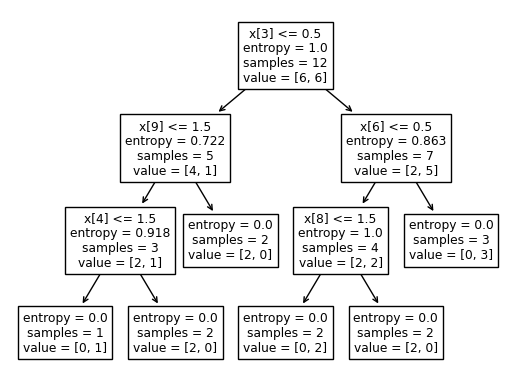

In [19]:
columns = ['Alternate_Available', 'Bar', 'Friday', 'Hungry', 'Patrons', 'Price',
       'Rain', 'Reservation', 'Type', 'Estimated_Wait_Time']
X = dataframe.loc[:, columns]
y = dataframe.loc[:, 'WillWait']

le = preprocessing.LabelEncoder()

# Apply label encoding to each column in X
for column in X.columns:
    X[column] = le.fit_transform(X[column])

# Apply label encoding to y
y = le.fit_transform(y)


# create and print the decision tree
dtc = tree.DecisionTreeClassifier(criterion="entropy")
dtc.fit(X, y)  #latest line added
tree.plot_tree(dtc)


In [286]:
# Prepare the prediction data
prediction_data = ["Yes", "No", "Yes", "Yes", "Full", "$$", "No", "No", "Italian", ">60"]  # List of input data to predict
dataset_prediction = np.array([["Yes", "No", "Yes", "Yes", "Full", "$$", "No", "No", "Italian", ">60"]])
p = pd.DataFrame(dataset_prediction)

# Encode the prediction data using the original label encoder
encoded_prediction_data = label_encoder_X.fit_transform(prediction_data)
encoded_prediction_data

array([5, 4, 5, 5, 2, 0, 4, 4, 3, 1], dtype=int64)

In [78]:
#user interface
print('we need 12 criteria from you to determine whether or not you will wait')
alternative=input("please indicate whether or not you have an alternative resturant nearby(yes or no)").lower()
yesOrNo=['yes','no']
while(alternative not in yesOrNo ):
    print("the answer must be yes or no")
    alternative=input("please indicate whether or not you have an alternative resturant nearby(yes or no)").lower()

bar=input("please indicate whether or not the resturant has a bar(yes or no)").lower()
while(bar not in yesOrNo ):
    print("the answer must be yes or no")
    bar = input("please indicate whether or not the resturant has a bar(yes or no)").lower()


Weekend=input("please indicate whether or not its weekend(yes or no)").lower()
while(Weekend not in yesOrNo ):
    print("the answer must be yes or no")
    Weekend = input("please indicate whether or not its weekend(yes or no)").lower()

Hungry=input("please indicate whether or not your hungry(yes or no)").lower()
while(Hungry not in yesOrNo ):
    print("the answer must be yes or no")
    Hungry = input("please indicate whether or your hungry(yes or no)").lower()

Patron=input("how many people are in the resturant( None, Some, and Full)").lower()
patronAllowed=['none','some','full']
while(Patron not in patronAllowed):
    print("the answer must be none or some or full")
    Patron = input("how many people are in the resturant( None, Some, and Full)").lower()
price=input("please indicate the price of the resturant($,$$,$$$)").lower()
priceAllowed=['$','$$','$$$']
while(price not in priceAllowed):
    print("the price must be $,$$,$$$")
    price = input("please indicate the price of the resturant($,$$,$$$)").lower()

rain=input("please indicate if its raining outside(yes or no)").lower()
while(rain not in yesOrNo ):
    print("the answer must be yes or no")
    rain=input("please indicate if its raining outside").lower()

Reservation=input("please indicate whether or not (yes or no)")
while(Reservation not in yesOrNo ):
    print("the answer must be yes or no")
    Reservation = input("please indicate whether or not (yes or no)")

typeOfRes=input("please indicate the type of the resturant(french or thai or italian or burger").lower()
TypeOftheRes=['french','thai','burger','italian',]
while(typeOfRes not in TypeOftheRes):
    print("the types are italian and burger and thai and french")
    typeOfRes = input("please indicate the type of the resturant(french or thai or italian or burger").lower()

Waitestimate=input("please indicate the wait estimate given by the host (miuetes by number)").lower()

while(Waitestimate.isdigit() is not True):
    print("please enter a number")
    Waitestimate = input("please indicate the wait estimate given by the host (miuetes by number)").lower()

WaitestimateNumber =int(Waitestimate)

while(WaitestimateNumber<0):
    print("the number must be greater than 0")
    Waitestimate = input("please indicate the wait estimate given by the host (miuetes by number)").lower()

if(WaitestimateNumber<10):
    Waitestimate='0-10'
elif (WaitestimateNumber<30):
    Waitestimate = '10-30'
elif (WaitestimateNumber < 60):
    Waitestimate = '30-60'
elif (WaitestimateNumber > 60):
    Waitestimate = '>60'

print("your wait estimate category is ", Waitestimate)

VectorOfInputs=[alternative,bar,Weekend,Hungry,Patron,price,rain,Reservation,TypeOftheRes,Waitestimate]
willWait=predict(VectorOfInputs)
print("will you wait?",willWait)


we need 12 criteria from you to determine whether or not you will wait


KeyboardInterrupt: Interrupted by user